In [1]:
NOTEBOOK_NAME = "e007_add_sml_cd"

In [2]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import japanize_matplotlib

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from tqdm.auto import tqdm

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
# 再現性確保!
seed_everything(33)

In [3]:
INPUT_DIR = "../data"
OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
glob(os.path.join(INPUT_DIR, "*"))

['../data/train_log.csv',
 '../data/test_log.csv',
 '../data/image_embeddings.parquet',
 '../data/atmaCup16_Dataset.zip',
 '../data/train_label.csv',
 '../data/yado.csv',
 '../data/test_session.csv',
 '../data/sample_submission.csv']

In [5]:
sorted(glob(os.path.join(INPUT_DIR, "*")))

['../data/atmaCup16_Dataset.zip',
 '../data/image_embeddings.parquet',
 '../data/sample_submission.csv',
 '../data/test_log.csv',
 '../data/test_session.csv',
 '../data/train_label.csv',
 '../data/train_log.csv',
 '../data/yado.csv']

In [6]:
# 学習用のログデータと正解ラベル
train_log_df = pd.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label_df = pd.read_csv(os.path.join(INPUT_DIR, "train_label.csv"))

# 宿のデータ
yado_df = pd.read_csv(os.path.join(INPUT_DIR, "yado.csv"))

# テスト期間のログデータ
test_log_df = pd.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))

sample_submission_df = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))

In [7]:
# すべてのログデータはあとあと参照をするので先に作っておきます.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

今回の講座では、単純にログデータに出現する宿のIDにからランダムに N=10 をサンプルすることにしましょう。

すごく愚直に実装をすると以下のようになります。

上記はわかりやすさのために for 文で記載をしました。ただちょっと遅い (1分ぐらいかかる) ので少し工夫して高速化しましょう。

In [8]:
N = 10
sessions = train_label_df["session_id"].unique()

session_yad_df = pd.DataFrame(
    {
        "session_id": [x for s in sessions for x in [s] * N],
        "yad_no": yado_df["yad_no"].sample(n=N * len(sessions), replace=True).values,
    }
)

高速化と言っても単純に N * セッション分の宿Noを一気に生成するように変えただけです。(厳密には同じセッションで重複する宿Noが存在する可能性があるため、全く同じではないですが被らなければ一緒です。) python では for が遅いのでこのように numpy などの機能で一気に計算できる場合にはそちらを使うように書き換えると数十倍程度高速化する場合があります。

----

さてこれでランダムに宿Noを用意することには成功しました。

ランダムに取ってきた宿以外の候補として有力なのが、セッション中に出てくる宿です。普通に考えて同一セッションに出てきた宿は選ばれる可能性が高そうですし、負例の候補としてはもってこいですね。これも先のランダムな宿と一緒に追加しましょう。

In [9]:
# ランダムな宿にログ中の宿を追加する
session_yad_df = pd.concat(
    [session_yad_df, train_log_df[["session_id", "yad_no"]]], ignore_index=True
)

これで予約しなかった宿の組を作ることができました。

### セッション・宿の組み合わせデータの作成

上記を取りまとめて、ログデータを元にしてあるセッションに対して

* ランダムに選ぶ宿
* ログ中に出てくる宿

を紐付けるような関数を作成しましょう。

In [10]:
def create_session_yad_df(input_df: pd.DataFrame):
    """input_df には train_log / test_log のいずれかが来ることを想定している"""

    sessions = input_df["session_id"].unique()
    out_df = pd.DataFrame(
        {
            "session_id": [x for s in sessions for x in [s] * N],
            "yad_no": yado_df["yad_no"]
            .sample(n=N * len(sessions), replace=True)
            .values,
        }
    )

    # ランダムに付け加えたもの以外・同一ログに出現する宿を候補にいれる
    out_df = pd.concat([out_df, input_df[["session_id", "yad_no"]]], ignore_index=True)

    # 重複は意味がないので消します。
    out_df = out_df.drop_duplicates()

    # 見た目を揃えるために session / yad の順番でソートをします
    out_df = out_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

    return out_df

In [11]:
train_session_yad_df = create_session_yad_df(input_df=train_log_df)

# 予測の際には session ごとに yado に対しての予約確率を出さなくてはなりませんから、同じように session - yado の組を作ります。
# ただし学習時と同じような組で良いか? は議論が必要かもしれません. (ここに現れない宿は予測対象に絶対入らないため)
test_session_yad_df = create_session_yad_df(input_df=test_log_df)

ただこれだけでは足りない部分がありますので、後処理として対応をしましょう。

### 学習用データへの後処理: 正例の紐付け

学習用データにはセッションごとに予約された宿の紐付いたデータが提供されています。この組み合わせを使わないと正例の一部を捨てることになってしまってもったいないですから、今作った組に正例の組を結合させるようにします。具体的に言うと以下のような流れです。

* まず `train_session_yad_df` にたいして正解ラベルの session / yado の組み合わせを付与
* session_id / yad_no の重複を削除 (これはもしランダムにつくった yad_no に正解がある場合に発生します)
* session_id / yad_no が train_label_df に含まれているかのラベル情報を作成

In [12]:
# 正解ラベル train_label_df の組み合わせを付与
_df = pd.concat([train_label_df, train_session_yad_df], ignore_index=True)

# 重複を削除して
_df = _df.drop_duplicates().reset_index(drop=True)

# 正解ラベルに含まれているレコードの index を配列で取得して
target_index = pd.merge(
    _df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner"
)["index"].values

# 正解Indexに含まれている場合 1 / そうでないと 0 のラベルを作成
_df["target"] = _df.index.isin(target_index).astype(int)

# 見た目を揃えるために session / yad でソートしておく
_df = _df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

_df.head(21)

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,822,0
1,000007603d533d30453cc45d0f3d119f,1272,0
2,000007603d533d30453cc45d0f3d119f,2395,0
3,000007603d533d30453cc45d0f3d119f,3740,0
4,000007603d533d30453cc45d0f3d119f,4101,1
5,000007603d533d30453cc45d0f3d119f,4523,0
6,000007603d533d30453cc45d0f3d119f,4844,0
7,000007603d533d30453cc45d0f3d119f,6461,0
8,000007603d533d30453cc45d0f3d119f,8050,0
9,000007603d533d30453cc45d0f3d119f,11025,0


In [13]:
train_session_yad_df = _df.copy()

<Axes: xlabel='yad_no'>

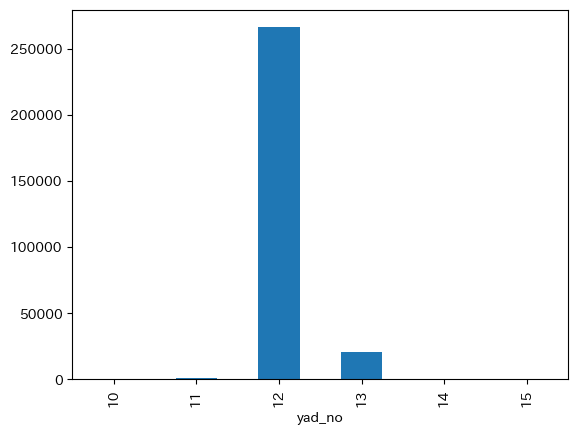

In [14]:
train_session_yad_df.groupby("session_id")[
    "yad_no"
].nunique().value_counts().sort_index().plot(kind="bar")

### テストデータへの後処理: ログの一番最後の宿の削除

テスト用データは最終的に「この宿に泊まってる?」を予測する対象になる宿を定義することになります。今回のデータは「ログデータの一番最後の宿は必ず正解ラベルではない」という制約条件があるので、セッションの最後の宿は取り去る処理を行っておきましょう。

In [15]:
def remove_last_yad_id(session_yad_df):
    # セッション中一番最後の宿の組を作成
    last_yad_df = whole_log_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]

    # 最後であることがわかるようにラベル is_last を付与
    last_yad_df["is_last"] = 1

    # 引数の session - yad の組み合わせとマージして
    merged = session_yad_df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")

    # is_last **ではない** (i.e. is_last is null) データのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = session_yad_df[idx_use].reset_index(drop=True)

    return out_df


test_session_yad_df = remove_last_yad_id(test_session_yad_df)

<Axes: xlabel='yad_no'>

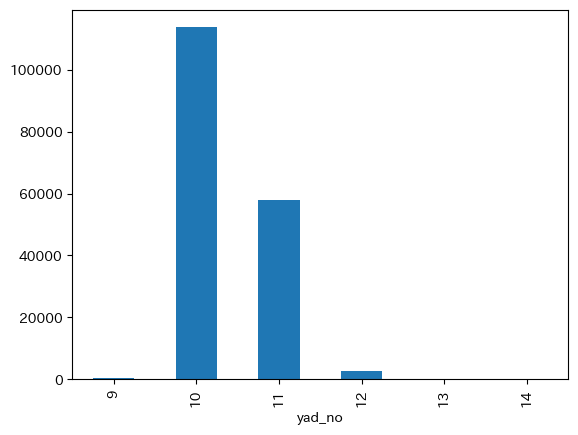

In [16]:
test_session_yad_df.groupby("session_id")[
    "yad_no"
].nunique().value_counts().sort_index().plot(kind="bar")

## 特徴量の作成

学習に使う宿が決まりました! 次は機械学習モデルがそのパターンンを認識できるような属性情報をデータに付与していきます。このようにデータに紐づく属性のことを特徴量と呼びます。特徴量をどのように作るか?は機械学習の性能を決める上で大変重要です。

今回は `session_id` / `yad_no` の2列がありますからこれらの列の情報を使うことができます。

### セッションの情報

セッションに紐づくような情報はありませんが、セッションがどのぐらいの長さだったか?の情報は使えそうです。

In [17]:
session_length = whole_log_df.groupby("session_id")["seq_no"].max()

In [18]:
def create_session_length_feature(input_df: pd.DataFrame):
    session_length = (
        whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")
    )

    out_df = pd.merge(
        input_df["session_id"], session_length, on="session_id", how="left"
    ).drop(columns=["session_id"])
    return out_df

In [19]:
create_session_length_feature(train_session_yad_df)

,session_length
0,0
1,0
2,0
3,0
4,0
...,...
3484697,1
3484698,1
3484699,1
3484700,1


In [20]:
# 2回同じ関数を使って特徴を作ったとき同一のデータができるか? をテストしておくと少し安心です
assert create_session_length_feature(train_session_yad_df).equals(
    create_session_length_feature(train_session_yad_df)
)

### 宿の情報

次に考えられるのは宿の情報です。宿にはマスター情報が付随していますのでこれを使うことができます。

In [21]:
yado_df.dtypes

yad_no                 int64
yad_type               int64
total_room_cnt       float64
wireless_lan_flg     float64
onsen_flg              int64
kd_stn_5min          float64
kd_bch_5min          float64
kd_slp_5min          float64
kd_conv_walk_5min    float64
wid_cd                object
ken_cd                object
lrg_cd                object
sml_cd                object
dtype: object

In [22]:
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]

    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(
        input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left"
    ).drop(columns=["yad_no"])
    return out_df

In [23]:
create_yado_numaric_feature(train_session_yad_df)

,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min
0,0,134.0,1.0,0,NaN,NaN,NaN,1.0
1,0,7.0,1.0,1,NaN,NaN,NaN,NaN
2,0,113.0,1.0,0,NaN,NaN,NaN,NaN
3,0,10.0,1.0,1,NaN,NaN,NaN,1.0
4,0,39.0,NaN,0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
3484697,0,56.0,NaN,1,NaN,NaN,NaN,1.0
3484698,0,150.0,1.0,0,1.0,NaN,NaN,1.0
3484699,0,100.0,1.0,0,1.0,NaN,NaN,1.0
3484700,0,70.0,1.0,0,NaN,NaN,NaN,1.0


In [24]:
assert create_yado_numaric_feature(train_session_yad_df).equals(
    create_yado_numaric_feature(train_session_yad_df)
)

宿には他にも wid_cd などカテゴリ扱いの列もあります。これらは直接はモデルにいれることはできないため、数値に変換する必要があります。よくある方法として LabelEncoding や OneHotEncoding, CountEncoding などがあります。今回は LabelEncoding を使って見ます。

In [28]:
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder

# 使い方はシンプルで, LabelEncoder を定義したあと fit_trainsform で与えられた配列を数値 Label に変換します。
le = LabelEncoder()

wid_cd_label = le.fit_transform(yado_df["wid_cd"])
sml_cd_label = le.fit_transform(yado_df["sml_cd"])

In [29]:
def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame(
        {"yad_no": yado_df["yad_no"], "wid_cd_label": wid_cd_label}
    )

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(
        columns=["yad_no"]
    )
    return out_df


def create_yad_sml_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame(
        {"yad_no": yado_df["yad_no"], "sml_cd_label": sml_cd_label}
    )

    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(
        columns=["yad_no"]
    )
    return out_df

In [37]:
create_yad_wid_cd_feature(train_session_yad_df)

,wid_cd_label
0,4
1,3
2,9
3,10
4,9
...,...
3484697,11
3484698,10
3484699,9
3484700,10


In [38]:
assert create_yad_wid_cd_feature(train_session_yad_df).equals(
    create_yad_wid_cd_feature(train_session_yad_df)
)

### 特徴量のマージ

上記の特徴量作成関数を連続的に呼び出し & 結合して、学習に使う特徴量全体にしましょう。

In [30]:
# いままでの関数をすべてがっちゃんこして特徴量を作成する関数を定義しましょう!


def create_feature(input_df):
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
        create_yad_sml_cd_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [31]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_session_length_feature 0.585[s]
- create create_yado_numaric_feature 0.178[s]
- create create_yad_wid_cd_feature 0.134[s]
- create create_yad_sml_cd_feature 0.128[s]
train... 1.107[s]
- create create_session_length_feature 0.467[s]
- create create_yado_numaric_feature 0.102[s]
- create create_yad_wid_cd_feature 0.069[s]
- create create_yad_sml_cd_feature 0.067[s]
test... 0.745[s]


## モデルの学習

特徴量を作成できたので次にモデルの学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

* 一番ナイーブな戦略は Random と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。
* ターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。
* 「各分割で特定のグループが重ならないようにする」Group もよく使われます。

---

今回は train / test で session が分けられていることを加味して session_id の Group で分割する方法を利用します。

In [36]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_session_yad_df["session_id"].values)
cv = list(cv)  # split の返り値は generator なので list 化して何度も iterate できるようにしておく

### LightGBM による CrossValidation を用いた学習

今回は使う機械学習モデルとして lightGBM を使います。lightGBM は以下のような良い性質があります。

* GBDT と呼ばれるアルゴリズムの一種でテーブルデータで性能が高いことが知られている
* 欠損値が存在している場合にも自然に取り扱えるため特に処理が必要ない
* 特徴量のスケールを揃えたりしなくてよい
* 特徴重要度をさっと出すことができる
* CPU 環境でも高速に学習・推論が行える

u++ さんの [「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617) などが参考になります。

> ref: https://lightgbm.readthedocs.io/en/stable/

In [37]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_squared_log_error,
    median_absolute_error,
    explained_variance_score,
    cohen_kappa_score,
    average_precision_score,
    precision_score,
    recall_score,
)


def binary_metrics(
    y_true: np.ndarray, predict_probability: np.ndarray, threshold=0.5
) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [accuracy_score, f1_score, precision_score, recall_score]

    prob_functions = [roc_auc_score, log_loss, average_precision_score]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores


def fit_lgbm(X, y, cv, params: dict = None):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        print(f"-- start fold {i}")
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, verbose=0)

        with Timer(prefix="fit fold={} ".format(i)):
            # cv 内で train に定義された x_train で学習する
            clf.fit(
                x_train,
                y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=100, verbose=False),
                    lgbm.log_evaluation(
                        period=100,
                    ),
                ],
            )

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)
        print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

In [38]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します.
    "objective": "binary",
    # 木の最大数
    "n_estimators": 10000,
    # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    # 今回設定している 0.3 は比較的大きめの設定です
    "learning_rate": 0.3,
    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain",
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

-- start fold 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's binary_logloss: 0.255776
[200]	valid_0's binary_logloss: 0.253423
[300]	valid_0's binary_logloss: 0.252616
[400]	valid_0's binary_logloss: 0.252366
[500]	valid_0's binary_logloss: 0.253875
fit fold=0  12.578[s]
 - fold1 - {'accuracy_score': 0.9171271352421675, 'f1_score': 0.0017283993293810602, 'precision_score': 0.423728813559322, 'recall_score': 0.0008659658116697553, 'roc_auc_score': 0.7612249849674628, 'log_loss': 0.2520006714313267, 'average_precision_score': 0.21151523279657702}
-- start fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100

## 結果を解釈する

モデルができた! 次は予測だ! の前に… 一度予測結果の見積もりを行いましょう。

### 手元でスコアを見積もる

予測時には 5 Fold に分けてモデルを作りましたので `oof` に含まれるデータは完全に正解情報を知らない状態で予測された確率になっています。これを使って今回の指標 MAP@10 のスコアを見積もって見ましょう。

まずは予測確率ともとのセッション・宿情報から、セッションごとに予測確率の高い宿Noを10件取得しましょう。これはあとでテストデータに対しても同じことをしますので、関数にしておくと便利ですね。

In [39]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat(
        [session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]

    out_df = out_df.fillna(0).astype(int)

    return out_df

In [40]:
oof_label_df = create_top_10_yad_predict(
    predict=oof, session_yad_df=train_session_yad_df
)

oof_label_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,4523,11025,822,3740,4844,8050,2395,4101,12477,6461
0000ca043ed437a1472c9d1d154eb49b,13682,7502,13535,11705,8253,2029,10016,713,3866,1210
0000d4835cf113316fe447e2f80ba1c8,11192,13265,5495,8304,6694,4822,5559,4863,6691,12567
0000fcda1ae1b2f431e55a7075d1f500,1652,12320,5999,9270,1276,8186,8475,12813,8592,12439
000104bdffaaad1a1e0a9ebacf585f33,11512,96,898,7787,13125,6100,8205,10817,4510,2691
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,8140,2259,12464,2131,1502,3066,7306,3695,13697,12332
ffff2360540745117193ecadcdc06538,846,10832,4923,6721,963,6215,8666,2121,7058,6884
ffff7fb4617164b2604aaf51c40bf82d,13719,7183,6257,1680,1367,1550,5196,7577,6972,12417


今回の評価指標は MAP@10 です。計算方法は https://www.guruguru.science/competitions/22/discussions/a62aed5d-438d-46c7-8e44-85e5e5d41e64/ の @camaro さんコードを引用しました。

In [41]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [42]:
# いま作成した session_id と同じ並びで train_label を並び替え
train_label = (
    train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [43]:
# MAPK (k=10) として計算
oof_score_mapk = mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)
oof_score_mapk

0.4609236699476996

学習時の見積もりとして性能は `0.444` となりました。これは今のLBだとかなり2位を引き離して1位ですね。

#### note: 見積もりに含まれているバイアス

学習時には正解の宿をセッションに含める実装をしたのを思い出してください。これによって、この性能見積もりには「予測している宿Noのなかに必ず正解の宿Noが含まれている」という前提が含まれることになっています。

実際にテストデータを予測する際にはどれが予約されたかわからない状態で推論する必要があるため、この性能は過剰な見積もりになっているだろうことが伺えます。カジュアルにいうと「絶対にこの候補の中に正解があるぞ!」という状態で見積もっているのですが、テスト時にはその確証はなく「もしかしたらこの中には一つも正解は無いかもしれない」という状態で予測するため、性能が過剰に見積もられたいわば下駄が履かされている状態になっている、ということです。

#### FutureWork

* バイアスを取り除いて評価をする方法は無いでしょうか?

### 予測モデルの中身を理解する

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。また何故この予測が出てくるかの解釈をする上でも有用です。

> note: 今回利用した lightGBM は内部的に特徴の値での IF をたくさん重ねているモデルなので、どの特徴で IF を作っているか + それによって予測性能がどのぐらい改善するかを利用して特徴量ごとの貢献度 (特徴重要度) を算出することができます。

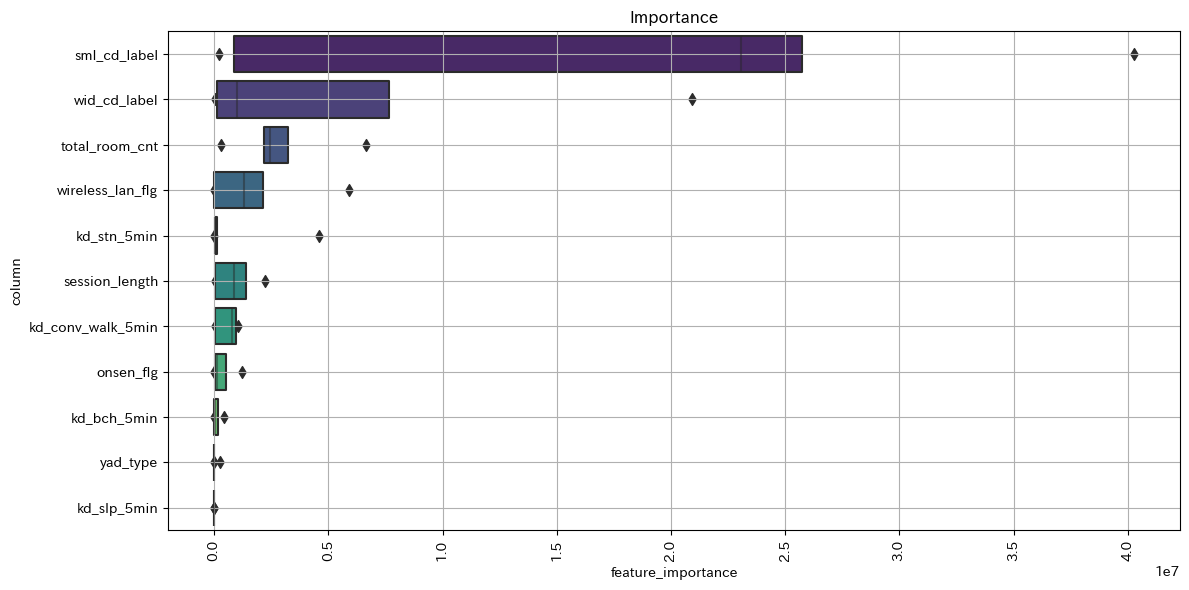

In [44]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, train_feat_df)

## 推論する

学習したモデルを使ってテストデータに対しての予測を行いましょう。

In [45]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (5, N_test,).
pred_prob = np.array(
    [model.predict_proba(test_feat_df.values)[:, 1] for model in models]
)

In [46]:
# k 個のモデルの予測値の平均 shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0)  # axis=0 なので shape の `k` が潰れる

### 予測値の確認

予測結果が学習時の結果と差が出ていないかを確認しましょう。具体的には out of fold の予測確率の分布と test への予測確率の分布を見て大きなズレがないかなどを見ると良いです。このとき予期せぬズレが発生している場合には実装が間違っている場合や、テスト時に使えない情報を学習時に使っている場合などがあります。

勢い良く submit をする前に一度確認しておくと良いです🫑( '-' 🫑)

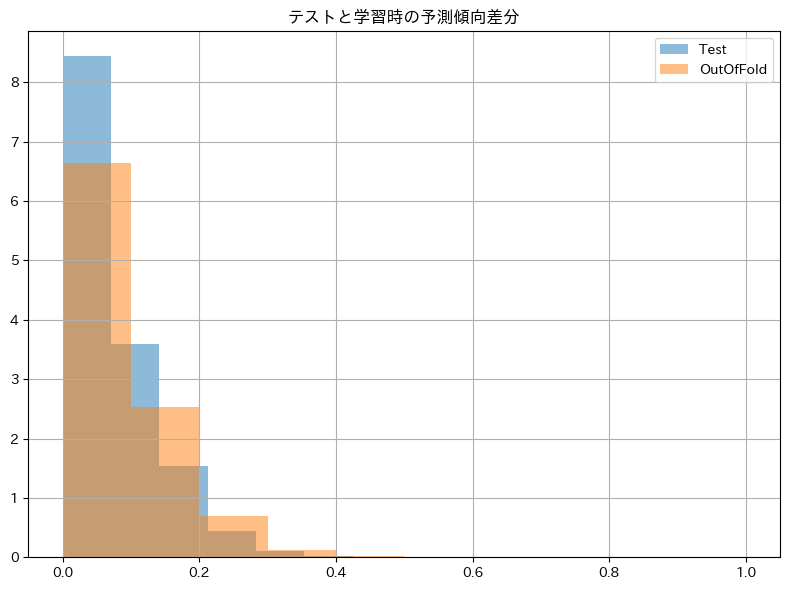

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred_prob, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [48]:
test_pred_df = create_top_10_yad_predict(
    predict=pred_prob, session_yad_df=test_session_yad_df
)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_").to_csv(
    f"../sub/{NOTEBOOK_NAME}_{oof_score_mapk:.4f}.csv",
    index=False,
)

In [49]:
test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
00001149e9c73985425197104712478c,3560,12366,10615,11525,1241,6503,6831,6789,1772,5509
0000e02747d749a52b7736dfa751e258,12573,1523,12896,9161,11914,10243,10833,6636,13028,8532
0000f17ae2628237d78d3a38b009d3be,2711,1577,13592,757,2881,11916,12566,2283,8481,10841
000174a6f7a569b84c5575760d2e9664,6178,8094,1055,12341,3226,8839,2950,12873,3513,10714
00017e2a527901c9c41b1acef525d016,9193,12925,12198,3067,5875,8166,5499,8449,7608,4967


## Future Work

* セッション・宿の組の深堀り
    * 学習用・テスト用のセッションと宿の組み合わせはかなり naive なものを利用しましたが、この候補の選び方が良い・悪いで性能に大きな差がでることが予想されます。例えばテスト用の候補の中に一件も正解の宿が無いとすると、どれだけ予測性能が高いモデルを作れたとしてもひとつも正解を当てることはできません。より良い宿の候補を選ぶにはどうすれば良いか?を考えるのは大変意味がありそうです。
* 特徴量の追加
    * 今回の特徴量はセッションの長さと宿の基本的属性のみでした。それ以外にもセッション-宿の組み合わせから計算できる特徴量はあるでしょう。それらを追加してより機械学習モデルがいろんな情報を使えるようにすると性能が向上するかもしれません。
* LightGBM 以外のモデルの活用 (やや難しい)
    * 今回は初手として有能な勾配ブースティングモデルLightGBMをご紹介しましたが、それ以外にもモデルはたくさん提案されています。レコメンドの文脈でよく出てくるモデルや、ログベースのデータから予測するような問題で使われるモデルなどを試すのも良いでしょう